# IMPORTS

In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
from os import listdir
from os.path import isfile, join
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.models import load_model
import matplotlib.pyplot as plt
from utils import Utils

In [2]:
img_size = (224, 224)
num_persons = 4
batch_size=32
NUM_EPOCHS=10


# Dataset Preparation

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2)

In [4]:
train_generator = train_datagen.flow_from_directory(
    'data',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 44 images belonging to 3 classes.


In [5]:
val_generator = train_datagen.flow_from_directory(
    'data',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 9 images belonging to 3 classes.


# Fine-Tuning VGG16

In [6]:
vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (224,224, 3))

In [7]:
for layer in vgg.layers[:-4]:
    layer.trainable = False

for layer in vgg.layers[-4:]:
    layer.trainable = True

In [8]:
model = Model(inputs = vgg.input,outputs = vgg.output)

In [9]:
FC_Head = Utils.replace_top(vgg, num_persons,train_generator)

model = Model(inputs = vgg.input, outputs = FC_Head, name='fine-tune-vgg16')

print(model.summary())

Model: "fine-tune-vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,692,355 (105.64 MB)

 Trainable params: 20,057,091 (76.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

None


In [10]:
history=Utils.compile_fit_save(model,train_generator,val_generator,NUM_EPOCHS,model_name='fine-tune-vgg16')

c:\Users\Seif Yasser\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10


c:\Users\Seif Yasser\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.2980 - loss: 9.2194 - val_accuracy: 0.5556 - val_loss: 0.9964
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3267 - loss: 1.2630 - val_accuracy: 0.5556 - val_loss: 1.0128
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4975 - loss: 1.0535 - val_accuracy: 0.5556 - val_loss: 2.3653
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4848 - loss: 2.0366 - val_accuracy: 0.2222 - val_loss: 1.0979
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3314 - loss: 1.0981 - val_accuracy: 0.2222 - val_loss: 1.0978
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3359 - loss: 1.0971 - val_accuracy: 0.2222 - val_loss: 1.0844
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3409 - loss: 1.0921 - val_accuracy: 0.2222 - val_loss: 1.2062
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3059 - loss: 1.1705 - val_accuracy: 0.2222 - val_loss: 1.1513
Epoch 9/10
2/2 ━━━━━━━━━━━━

# Transfer Learning VGG16

In [11]:
vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (224,224, 3))

In [12]:
for layer in vgg.layers:
    layer.trainable = False

In [13]:
model = Model(inputs = vgg.input,outputs = vgg.output)

In [14]:
FC_Head = Utils.replace_top(vgg, num_persons,train_generator)

model = Model(inputs = vgg.input, outputs = FC_Head, name='transfer-learning-vgg16')

print(model.summary())

Model: "transfer-learning-vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,692,355 (105.64 MB)

 Trainable params: 12,977,667 (49.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [15]:
history=Utils.compile_fit_save(model,train_generator,val_generator,NUM_EPOCHS,model_name='transfer-learning-vgg16.h5')

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4138 - loss: 2.7608 - val_accuracy: 0.2222 - val_loss: 2.2490
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.6288 - loss: 3.0157 - val_accuracy: 0.6667 - val_loss: 1.4718
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.5025 - loss: 1.9885 - val_accuracy: 0.2222 - val_loss: 2.7051
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4896 - loss: 2.0469 - val_accuracy: 0.6667 - val_loss: 1.1211
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5095 - loss: 2.1038 - val_accuracy: 0.6667 - val_loss: 1.9457
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6490 - loss: 1.2236 - val_accuracy: 0.6667 - val_loss: 1.7129
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6477 - loss: 1.6736 - val_accuracy: 0.5556 - val_loss: 1.3720
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.5909 - loss: 1.3223 - val_accuracy: 0.3333 - val_loss: 1.4581
Epoch 9/10
2/2 ━

# One-Shot Learning

## FaceNet

In [16]:
from keras_facenet import FaceNet
from scipy.spatial.distance import cosine
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

### K-NN

In [17]:
embedder=FaceNet()

In [18]:
dataset_path = 'data'
persons =Utils.prepare_embeddings(dataset_path,embedder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [19]:
X_train = np.array(list(persons.values()))
y_train = list(persons.keys())

In [20]:
knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
messi


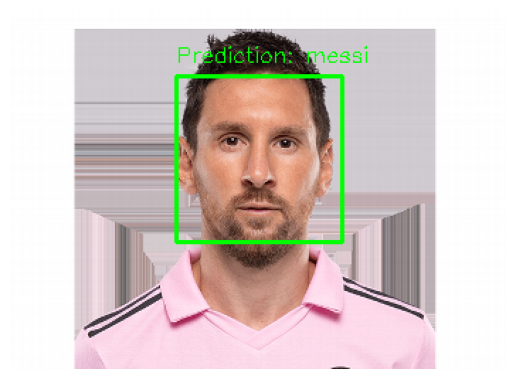

In [21]:
Utils.predict_person('data/messi/3.jpeg',train_generator.class_indices,knn,embedder,le)

### SVM

In [22]:
X_train = np.array(list(persons.values()))
y_train = np.array(list(persons.keys()))

In [23]:
y_train_encoded=le.fit_transform(y_train)

In [24]:
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train_encoded)

SVC(kernel='linear', probability=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
messi


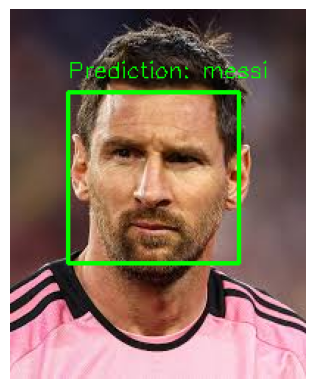

In [25]:
Utils.predict_person('data/messi/4.jpeg',train_generator.class_indices,svm_model,embedder,le)

## Siamese

In [ ]:
!# TODO: